In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import torchbnn as bnn


In [7]:

#import creep data
creep_df = pd.read_csv('../PI_Data/PI_Ti_alloys_dataset.csv')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress,Creep Life
0,89.980,5.79,3.86,0.07,0.030,0.000,0.000,0.12,0.0,0.00,...,800,0.67,800,0.66,1.100000e-05,3.90,0.729,700,45.0,1.00
1,87.810,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0,0.00,0,0.00,1.390000e-04,0.00,-4.529,600,319.0,0.17
2,89.256,6.33,4.00,0.20,0.030,0.010,0.004,0.17,0.0,0.00,...,0,0.00,190,6.00,1.570000e-04,17.40,-4.529,600,319.0,0.17
3,87.810,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0,0.00,950,1.00,1.390000e-04,17.40,-4.529,600,319.0,0.17
4,82.340,5.60,5.08,0.95,0.000,0.000,0.000,0.00,0.0,0.00,...,0,0.00,0,0.00,0.000000e+00,1.30,2.266,400,250.0,72.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,88.250,6.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,0.00,...,1050,0.50,550,24.00,1.440000e-07,26.22,2.474,500,300.0,328.28
149,48.000,48.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,2.00,...,0,0.00,1260,4.00,9.060000e-07,1.76,2.512,750,325.0,192.36
150,87.875,6.75,4.50,0.40,0.100,0.050,0.125,0.20,0.0,0.00,...,690,4.00,1050,0.50,9.720000e-08,11.20,2.512,500,319.0,224.00
151,85.260,5.70,0.00,0.00,0.040,0.000,0.000,0.00,4.8,0.69,...,1050,0.50,700,2.00,0.000000e+00,7.05,2.259,600,310.0,91.45


In [8]:
# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep Life'])
creep_df = creep_df.drop(['Creep Life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress,log_creep_life
0,89.980003,5.79,3.86,0.07,0.030,0.000,0.000,0.12,0.0,0.00,...,800.0,0.67,800.0,0.66,1.100000e-05,3.900000,0.729,700.0,45.0,0.000000
1,87.809998,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0.0,0.00,0.0,0.00,1.390000e-04,0.000000,-4.529,600.0,319.0,-0.769551
2,89.255997,6.33,4.00,0.20,0.030,0.010,0.004,0.17,0.0,0.00,...,0.0,0.00,190.0,6.00,1.570000e-04,17.400000,-4.529,600.0,319.0,-0.769551
3,87.809998,6.61,4.23,1.18,0.026,0.011,0.003,0.13,0.0,0.00,...,0.0,0.00,950.0,1.00,1.390000e-04,17.400000,-4.529,600.0,319.0,-0.769551
4,82.339996,5.60,5.08,0.95,0.000,0.000,0.000,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.000000e+00,1.300000,2.266,400.0,250.0,1.857332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,88.250000,6.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,0.00,...,1050.0,0.50,550.0,24.00,1.440000e-07,26.219999,2.474,500.0,300.0,2.516244
149,48.000000,48.00,0.00,0.00,0.000,0.000,0.000,0.00,0.0,2.00,...,0.0,0.00,1260.0,4.00,9.060000e-07,1.760000,2.512,750.0,325.0,2.284115
150,87.875000,6.75,4.50,0.40,0.100,0.050,0.125,0.20,0.0,0.00,...,690.0,4.00,1050.0,0.50,9.720000e-08,11.200000,2.512,500.0,319.0,2.350248
151,85.260002,5.70,0.00,0.00,0.040,0.000,0.000,0.00,4.8,0.69,...,1050.0,0.50,700.0,2.00,0.000000e+00,7.050000,2.259,600.0,310.0,1.961184


In [9]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Ti                               153 non-null    float32
 1   Al                               153 non-null    float32
 2   V                                153 non-null    float32
 3   Fe                               153 non-null    float32
 4   C                                153 non-null    float32
 5   N                                153 non-null    float32
 6   H                                153 non-null    float32
 7   O                                153 non-null    float32
 8   Sn                               153 non-null    float32
 9   Nb                               153 non-null    float32
 10  Mo                               153 non-null    float32
 11  Zr                               153 non-null    float32
 12  Si                    

In [10]:
# Extract features and targets
features = creep_df.iloc[:, 0:24]
targets = creep_df.iloc[:, 24]
features

,Ti,Al,V,Fe,C,N,H,O,Sn,Nb,...,Cr,Solution treated temp(cel),ST time (h),Anneal temp (cel),Annealing Time (hour),steady state strain rate (1/s),Strain to rupture (%) (Efc),PI_creep_feature,Temperature of creep test (cel),stress
0,87.875000,6.75,4.50,0.40,0.100,0.050,0.1250,0.20,0.00,0.0,...,0.0,690.0,4.0,1050.0,0.5,2.090000e-03,15.800000,-0.136,700.0,319.0
1,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,3.240000e-06,0.000000,-0.136,600.0,319.0
2,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,4.400000e-05,0.000000,-0.073,600.0,250.0
3,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,4.430000e-05,0.000000,2.470,500.0,520.0
4,87.809998,6.61,4.23,1.18,0.026,0.011,0.0030,0.13,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,2.130000e-03,0.000000,0.318,700.0,319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,85.987000,6.20,0.00,0.00,0.021,0.004,0.0080,0.03,1.95,0.0,...,0.0,900.0,1.0,580.0,8.0,1.200000e-04,0.000000,2.458,520.0,310.0
149,89.043404,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0.0,0.0,940.0,4.0,9.160000e-07,0.000000,2.664,455.0,379.0
150,89.043404,6.51,4.08,0.16,0.010,0.005,0.0016,0.19,0.00,0.0,...,0.0,0.0,0.0,1030.0,0.5,1.270000e-06,0.000000,2.664,455.0,379.0
151,89.410004,6.00,4.00,0.25,0.080,0.050,0.0100,0.20,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,9.000000e-07,22.299999,2.323,538.0,103.0


Run # 1 Fold # 1
MSE : 2.57, KL : 0.62
MSE : 0.34, KL : 0.90
MSE : 0.10, KL : 1.08
Pearson CC: 0.9443752657667353
R2 score: 0.8834073714213875
RMSE: 0.40076565742492676
MAE: 0.31669503450393677
********************
Coverage: 87.09677419354833
Interval Width: 0.9338126182556152
Composite Metric: 0.9209454700250241


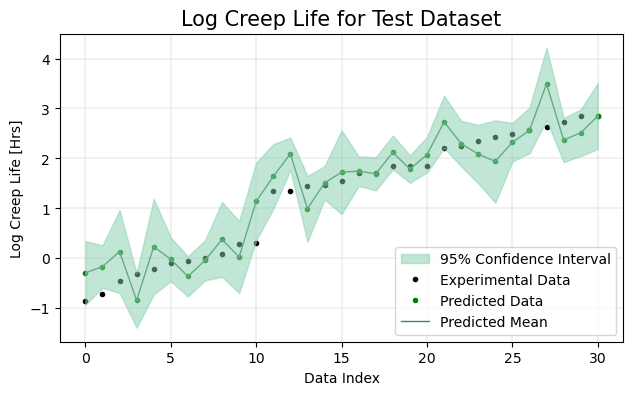

****************************************
Run # 1 Fold # 2
MSE : 3.16, KL : 0.63
MSE : 0.22, KL : 0.90
MSE : 0.09, KL : 1.06
Pearson CC: 0.9579617973715924
R2 score: 0.8958155552551343
RMSE: 0.46590396761894226
MAE: 0.3438871502876282
********************
Coverage: 74.19354838709674
Interval Width: 0.8626757264137268
Composite Metric: 0.8462476421009957


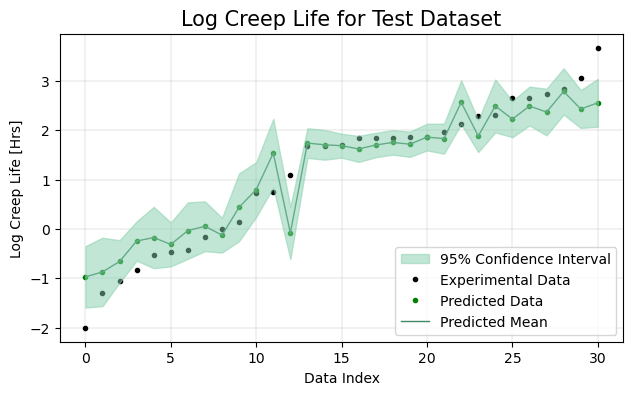

****************************************
Run # 1 Fold # 3
MSE : 3.77, KL : 0.62
MSE : 0.37, KL : 0.88
MSE : 0.17, KL : 1.02
Pearson CC: 0.9283024736748899
R2 score: 0.8560521336606242
RMSE: 0.5127313137054443
MAE: 0.32260018587112427
********************
Coverage: 74.19354838709674
Interval Width: 0.8849167823791504
Composite Metric: 0.8389640535960785


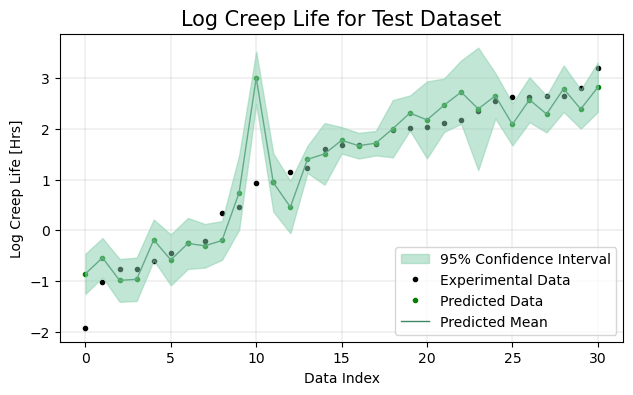

****************************************
Run # 1 Fold # 4
MSE : 2.67, KL : 0.62
MSE : 0.29, KL : 0.89
MSE : 0.16, KL : 1.06
Pearson CC: 0.9321590896768771
R2 score: 0.8635309165733698
RMSE: 0.43760281801223755
MAE: 0.32659712433815
********************
Coverage: 79.99999999999999
Interval Width: 0.9685439467430115
Composite Metric: 0.8581194181644435


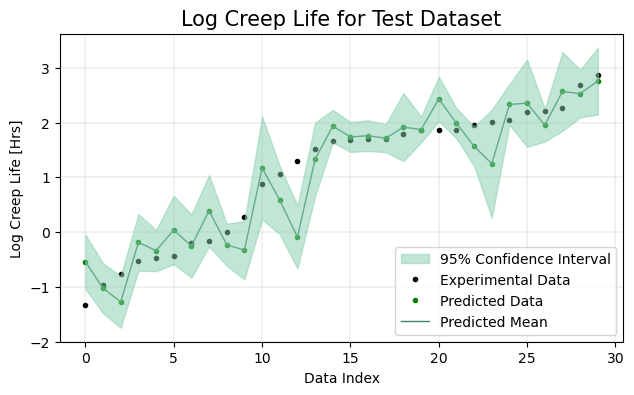

****************************************
Run # 1 Fold # 5
MSE : 3.38, KL : 0.62
MSE : 0.31, KL : 0.91
MSE : 0.16, KL : 1.06
Pearson CC: 0.8389489827652623
R2 score: 0.7014065476733582
RMSE: 0.5954928398132324
MAE: 0.4478907883167267
********************
Coverage: 66.66666666666667
Interval Width: 0.9183082580566406
Composite Metric: 0.7722397384610911


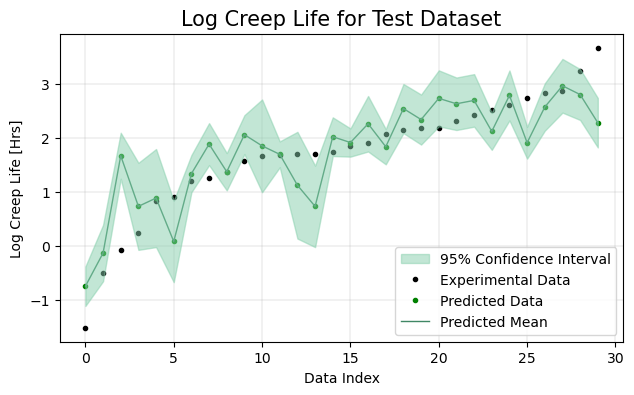

****************************************


In [11]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)


            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)
            y_train = torch.unsqueeze(y_train, dim=1)
            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)
            y_test = torch.unsqueeze(y_test, dim=1)


            # create pytorch dataset class
            class MyDataset(Dataset):
                def __init__(self, train_data, train_targets):
                    self.train_features = train_data
                    self.train_labels = train_targets

                def __len__(self):
                    return self.train_features.shape[0]

                def __getitem__(self, idx):
                    feature = self.train_features[idx]
                    label = self.train_labels[idx]

                    return feature, label


            train_dataset = train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
            model = nn.Sequential(
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=24, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=1),
            )

            # define the loss function and optimizer
            mse_loss = nn.MSELoss()
            kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
            kl_weight = 0.01

            optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.95)
            for step in range(3000):
                  for n, data in enumerate(train_dataloader):
                        traning_data, training_label = data


                        y_pred = model(traning_data)
                        mse = mse_loss(y_pred, training_label)
                        kl = kl_loss(model)
                        cost = mse + kl_weight*kl

                        optimizer.zero_grad()
                        cost.backward()
                        optimizer.step()

                  if step % 1000==0:
                        print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
            y_pred_test = model(x_test)

            # inference
            n_samples = 1000

            # compute predictions
            y_preds = [model(x_test).clone().detach().numpy() for _ in range(n_samples)]
            y_preds = np.array(y_preds)
            # mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

            ## Metrics for evaluating the uncertainty quantification of the model

            # Coverage
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')



            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()


            print(40*'*')

In [12]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.944375,0.883407,0.400766,0.316695
1,0.957962,0.895816,0.465904,0.343887
2,0.928302,0.856052,0.512731,0.322600
3,0.932159,0.863531,0.437603,0.326597
4,0.838949,0.701407,0.595493,0.447891


In [13]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.92035,0.042002,0.840043,0.070738,0.482499,0.06731,0.351534,0.049022


In [14]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,87.096774,0.933813,0.920945
1,74.193548,0.862676,0.846248
2,74.193548,0.884917,0.838964
3,80.000000,0.968544,0.858119
4,66.666667,0.918308,0.772240


In [15]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,76.430108,6.809568,0.913651,0.037055,0.847303,0.047424
